<a href="https://colab.research.google.com/github/MRedor/ML/blob/hw06/hw06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW06] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [0]:
import numpy as np
import copy
from sklearn.datasets import make_blobs, make_moons

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [0]:
class Module:
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, d):
        raise NotImplementedError()
        
    def update(self, alpha):
        pass
        
class Linear(Module):
    def __init__(self, in_features, out_features):
        t = 1 / np.sqrt(in_features)
        self.w = np.random.uniform(-t, t, (in_features, out_features))
        self.b = np.zeros(out_features)

    def forward(self, x):
        self.x = x
        return np.dot(x, self.w) + self.b

    def backward(self, d):
        self.d = d
        return np.dot(d, self.w.T)

    def update(self, alpha):
        self.w -= alpha * np.dot(self.x.T, self.d)
        self.b -= alpha * self.d.mean(axis = 0) * self.x.shape[0]
       
    
class ReLU(Module):
    def __init__(self):
        pass

    def forward(self, x):
        self.x = np.maximum(0, x)
        return self.x

    def backward(self, d):
        return d * (self.x > 0)
        
        
class Softmax(Module):
    def __init__(self):
        pass

    def forward(self, x):
        self.x = np.exp(x) / sum(np.exp(x))
        return self.x

    def backward(self, d):
        return d * self.x * (1 - self.x)

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [0]:
class MLPClassifier:
    def __init__(self, modules, epochs=40, alpha=0.01):
        self.modules = modules + [Softmax()]
        self.epochs = epochs
        self.alpha = alpha
            
    def fit(self, X, y):
        n = len(self.modules)
        for i in range(self.epochs):
            front = X.copy()
            for i in range(n):
                front = self.modules[i].forward(front)

            size = len(X)
            ans = np.zeros((size, len(np.unique(y))))
            ans[np.arange(size), y] = 1
            back = (front - ans) / size

            for i in range(n):
                current = self.modules[n - i - 1]
                back = current.backward(back)
        
    def predict_proba(self, X):
        result = X.copy()
        for i in range(len(self.modules)):
            result = self.modules[i].forward(result)
        return result
        
    def predict(self, X):
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)

In [0]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
])

X = np.random.randn(50, 4)
y = [(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X]
p.fit(X, y)

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [39]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)

best_acc = 0
for _ in range(25):
    p = MLPClassifier([
        Linear(2, 40),
        ReLU(),
        Linear(40, 80),
        Linear(80, 80),
        ReLU(),
        Linear(80, 40),
        Linear(40, 20),
        Linear(20, 10), 
        ReLU(),
        Linear(10, 2),
    ])

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.8925


In [29]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
best_acc = 0
for _ in range(25):
    p = MLPClassifier([
        Linear(2, 80),
        ReLU(),
        Linear(80, 120),
        ReLU(),
        Linear(120, 80),
        ReLU(),
        Linear(80, 3)
    ])

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.955


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [0]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("/datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("/datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:02, 70253834.25it/s]                               


Extracting /datasets/cifar10/cifar-10-python.tar.gz to /datasets/cifar10
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [0]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.lin = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.Linear(120, 84),
            nn.Linear(84, 10),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.lin(x)
        return x
        
def calculate_loss(X, y, model):
    return F.cross_entropy(model.forward(X), y)

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [0]:
def train(model, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [38]:
model = Model().to(device)
train_l, test_l = train(model)

Epoch 0 | Train loss 2.2521556816864012 | Test loss 2.1913139110565187
Epoch 1 | Train loss 2.148758543319702 | Test loss 2.1123259387969973
Epoch 2 | Train loss 2.0990522035980224 | Test loss 2.0791136882781984
Epoch 3 | Train loss 2.0727798274230955 | Test loss 2.0643129993438722
Epoch 4 | Train loss 2.0600695458984375 | Test loss 2.052592541885376
Epoch 5 | Train loss 2.0495953192138674 | Test loss 2.048155556488037
Epoch 6 | Train loss 2.0409027042388916 | Test loss 2.035593193435669
Epoch 7 | Train loss 2.0297833438110353 | Test loss 2.0230214092254637
Epoch 8 | Train loss 2.021015943222046 | Test loss 2.019719278717041
Epoch 9 | Train loss 2.0121589141082765 | Test loss 2.0119871627807617
Epoch 10 | Train loss 2.007831310958862 | Test loss 2.001854275894165
Epoch 11 | Train loss 1.996696937789917 | Test loss 1.995379386138916
Epoch 12 | Train loss 1.991981372833252 | Test loss 1.9899782066345215
Epoch 13 | Train loss 1.9818152695465088 | Test loss 1.9858867305755614
Epoch 14 | Tr

Построим график функции потерь

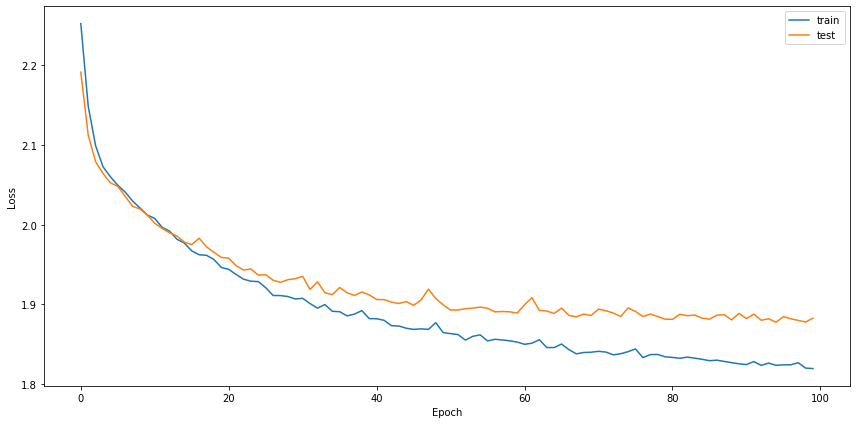

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [41]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.5756
Precision [0.69154229 0.74322733 0.48883375 0.38200474 0.53513514 0.48305085
 0.62009132 0.59461967 0.67853881 0.59542656]
Recall [0.556 0.631 0.394 0.484 0.495 0.456 0.679 0.641 0.743 0.677]
Mean Precision 0.5812470444070639
Mean Recall 0.5756
